In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
DAY=5

In [7]:
dim=(54, 4100, 1704)
def get_series(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b  
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba    

In [8]:
cat_lag_features={
 "city_0",
  "class_0",
  "cluster_0",
  "family_0",
  "state_0",
  "type_0",

 'city_mv36',
 'class_mv36',
 'cluster_mv36',
 'family_mv36',
 'state_mv36',
 'type_mv36',    
 
 'item_mean_0',
 'store_mean_0',
 }
cat_features={
 'holiday_0',
 'onpromotion_0',
 'wage_0',
 'd900'
 }
oil_features={'oil_0', 'oil_d1', 'oil_d10', 'oil_d15', 'oil_d3', 'oil_d5'}
sales_ma_features={'sales_ma_112',
 'sales_ma_14',
 'sales_ma_224',
 'sales_ma_28',
 'sales_ma_3',
 'sales_ma_56',
 'sales_ma_7'}
sales_season_ma_features={'sales_week_season_ma_p13',
 'sales_week_season_ma_p2',
 'sales_week_season_ma_p3',
 'sales_week_season_ma_p4',
 'sales_week_season_ma_p7'}

#move x, fix y
def _get_feature(name,lag=0,offset=0):
    if name in cat_lag_features :
        assert lag == 0
        if name in ['item_mean_0','class_mv36','family_mv36','class_0','family_0']:
            s=get_series2(name)
        else:
            s=get_series(name)
        return s_lag(s,offset)
    if name in cat_features or name in oil_features:
        assert offset==0 and lag==0
        s= get_series(name)
        if name =='holiday_0': s[np.isnan(s)]=0
        return s
    if name =="y_0" or name in sales_ma_features or name in sales_season_ma_features:
        #assert  lag == 0
        s=get_series(name)
        if offset==0 and lag==0: return s
        return s_lag(s,lag=offset+lag)
def get_feature(name,lag=0,offset=0):
    s=_get_feature(name=name,lag=lag,offset=offset)
    if s.shape == ( 4100,54, 1704):
        s=np.rollaxis(s,1,0)
    assert s.shape==(54, 4100, 1704), s.shape
    return s
def get_all_features(offset=1):
    assert offset>0
    all_features=[]
    for name in cat_lag_features:
        all_features.append({"name":name,"lag":0,"offset":offset})
    for name in cat_features:
        all_features.append({"name":name,"lag":0,"offset":0})   
#     for name in oil_features:
#         all_features.append({"name":name,"lag":0,"offset":0})  
    for i in range(0,7):
        all_features.append({"name":"y_0","lag":i ,"offset":offset})  
    for name in sales_ma_features:
        all_features.append({"name":name,"lag":0,"offset":offset})  
    for name in sales_season_ma_features:
        all_features.append({"name":name,"lag":(700-offset)%7,"offset":offset})
#     for i in range(1,8):
#         all_features.append({"name":"oil_0","lag":i,"offset":offset})              
    return all_features    
def calc_feature(feat):
    return get_feature(**feat)
def col_name(feat):
    return "{}-lag{}-offset{}".format(feat['name'],feat['lag'],feat['offset'])
def get_train_test(day):
    assert(day>0)
    cols=[]
    train_lst=[]
    
    for feat in get_all_features(day):
        col=col_name(feat)
        print col,
        arr=calc_feature(feat).astype(np.float16)
        train_lst.append(arr)
        cols.append(col)
        gc.collect()
        #break
    return cols,  np.array(train_lst)

In [14]:
def read_data(day):
    print "read data for day", day
    dirname='../input/d'+str(day)+"/"
    y=get_series('y_0')
    cols,train_test=get_train_test(day)
    cols=np.array(cols)    
    print "loaded", y.shape,train_test.shape 
    return cols,train_test,y.astype(np.float16)

In [10]:
%time cols,train_test,y=read_data(DAY)
rawy=y

read data for day 5
store_mean_0-lag0-offset5 family_0-lag0-offset5 city_0-lag0-offset5 cluster_mv36-lag0-offset5 cluster_0-lag0-offset5 city_mv36-lag0-offset5 item_mean_0-lag0-offset5 class_0-lag0-offset5 type_0-lag0-offset5 type_mv36-lag0-offset5 state_mv36-lag0-offset5 class_mv36-lag0-offset5 state_0-lag0-offset5 family_mv36-lag0-offset5 holiday_0-lag0-offset0 d900-lag0-offset0 onpromotion_0-lag0-offset0 wage_0-lag0-offset0 y_0-lag0-offset5 y_0-lag1-offset5 y_0-lag2-offset5 y_0-lag3-offset5 y_0-lag4-offset5 y_0-lag5-offset5 y_0-lag6-offset5 sales_ma_224-lag0-offset5 sales_ma_14-lag0-offset5 sales_ma_28-lag0-offset5 sales_ma_112-lag0-offset5 sales_ma_7-lag0-offset5 sales_ma_3-lag0-offset5 sales_ma_56-lag0-offset5 sales_week_season_ma_p7-lag2-offset5 sales_week_season_ma_p4-lag2-offset5 sales_week_season_ma_p13-lag2-offset5 sales_week_season_ma_p2-lag2-offset5 sales_week_season_ma_p3-lag2-offset5 loaded (54, 4100, 1704) (37, 54, 4100, 1704)
CPU times: user 2min 45s, sys: 27.2 s, total

In [15]:
print "types", [u.dtype for u in (cols, train_test, y)]
print "shapes", [u.shape for u in (cols, train_test, y)]
print "mem(gb)",np.round(train_test.nbytes/1024.**3,2), np.round(y.nbytes/1024.**3,2)

types [dtype('S37'), dtype('float16'), dtype('float16')]
shapes [(37,), (37, 54, 4100, 1704), (54, 4100, 1704)]
mem(gb) 26.0 0.7


In [16]:
train_test=np.rollaxis(train_test,0,4)
print "rolled train_test shape", train_test.shape

rolled train_test shape (54, 4100, 1704, 37)


In [17]:
gc.collect()

0

In [18]:
def show_data(store,item,date):
    thisy=y[store,item,date-10:date+10]
    a=train_test[store,item,date-10:date+10,:]
    a=np.squeeze(a)
    print a.shape
    df=pd.DataFrame(a,columns=cols,index=range(date-10,date+10))
    df['target']=thisy
    with pd.option_context('display.max_columns', None):
        display(df)

In [20]:
#show_data(0,1000,1688)

# cv

In [21]:
def make_data(low,high):
    y_train=y[:,:,low:high]
    X_train=train_test[:,:,low:high,:]
    ind=~np.isnan(y_train)
    a,b=X_train[ind],y_train[ind]
    #a=a.astype(np.float32,copy=False)
    #b=b.astype(np.float32,copy=False)
    print a.shape,b.shape,a.dtype,b.dtype
    return a,b 

In [22]:
X,y=make_data(100,1688)

(121371519, 37) (121371519,) float16 float16


In [23]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [24]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [25]:
print K.floatx()

float32


In [26]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [27]:
input_dim=X.shape[1]
input_dim

37

In [28]:
class TransformNALayer(Layer):

    def __init__(self,   **kwargs):
        super(TransformNALayer, self).__init__(**kwargs)
        self.supports_masking = True
    def build(self, input_shape):
        super(TransformNALayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x,training=None):
        def make_na(x):
            ind=tf.is_nan(x)
            filled_x=tf.where(ind, tf.zeros_like(x,dtype=np.float32), x)
            ind=tf.cast(ind,tf.float32)
            filled_x=tf.cast(filled_x,tf.float32)
            return  tf.cast(tf.concat([filled_x,ind],axis=1),tf.float32)
        def add_dropout(x):
            def f(x):
                ind=tf.random_uniform([1,37])<tf.random_uniform([1])[0]/tf.constant(5.0)
                ind2=tf.cast(ind,tf.float32)*tf.ones_like(x)
                newx=tf.where(ind2>0,tf.constant(np.nan,dtype=tf.float32)*tf.ones_like(x), x)
                return newx
            return tf.cond(tf.random_uniform([1])[0]>tf.constant(0.5),lambda: f(x),lambda : x)
        return K.in_train_phase(make_na(add_dropout(x)),make_na(x),training=training)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*2)        

In [29]:
X.shape

(121371519, 37)

In [30]:
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [31]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 1.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print "set learning rate to",lrate
   return lrate
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [32]:
#plt.plot([step_decay(u) for u in range(5)])

In [33]:
class KerasModel:
    def __init__(self,params={}):
        self.params=params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        model.add(TransformNALayer())
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss="mean_squared_error"
            if params['metric']=="mean_squared_error":
                this_metrics=['mean_squared_error']
            else:
                raise Exception("unknown")
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
                      metrics=None)
          #metrics=this_metrics)

        self.model=model
        return self
    def fit(self,X,y):
        params=self.params
        validation_split=params['validation_split']
        patience=params['patience']
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        #print "earlystopping on "+metric_name
        #self.name='day'+str(DAY)+'_adam.{epoch:02d}-{val_loss:.3f}.h5'
        self.name='day'+str(DAY)+'_adam.h5'
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, 
                                                     mode='auto', period=1)        
        batch_size=params['batch_size']
        self.hist=self.model.fit(X, y, batch_size=batch_size,epochs=200, 
                       validation_split=validation_split, 
                       #validation_data=(X_valid,y_valid),
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return self
    def load_best(self):
        return keras.models.load_model(self.name,
                                       custom_objects={'TransformNALayer':TransformNALayer})
    

In [34]:
param_grid={'input_dim':[(input_dim,)],
            'batch_size':[1024],
            'hidden_layer_sizes': [(256,256),()],
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "validation_split":[0.1],"patience":[3],
            "dropout_rate":[0.0],
            "activation":['relu'],    
            "l2":[1e-6,0],
            "epsilon":[0.1],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
len(parameters)

12

In [35]:
parameter=parameters[0]
parameter

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [36]:
def run_once(parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    a=KerasModel(parameter)
    a._make_model()
    h=a.fit(X,y)
    return [parameter,h.history]

In [37]:
if 0:
    backend.clear_session()
    set_session(tf.Session(config=config))    
    a=KerasModel(parameter)
    a._make_model()
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    for l in a.model.layers:
        print l, l.input_shape 
    display(SVG(model_to_dot(a.model).create(prog='dot', format='svg')))
   

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=KerasModel(parameter)
a._make_model()

<__main__.KerasModel instance at 0x7f97e220de18>

In [39]:
a.params

{'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 1024,
 'dropout_rate': 0.0,
 'epsilon': 0.1,
 'hidden_layer_sizes': (256, 256),
 'input_dim': (37,),
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3,
 'validation_split': 0.1}

In [40]:
a.fit(X,y)

Train on 109234367 samples, validate on 12137152 samples
Epoch 1/200
109234367/109234367 [==============================] - 756s 7us/step - loss: 0.2723 - val_loss: 0.2737
Epoch 2/200
109234367/109234367 [==============================] - 809s 7us/step - loss: 0.2687 - val_loss: 0.2748
Epoch 3/200
109234367/109234367 [==============================] - 808s 7us/step - loss: 0.2679 - val_loss: 0.2717
Epoch 4/200
109234367/109234367 [==============================] - 815s 7us/step - loss: 0.2676 - val_loss: 0.2710
Epoch 5/200
109234367/109234367 [==============================] - 810s 7us/step - loss: 0.2674 - val_loss: 0.2707
Epoch 6/200
109234367/109234367 [==============================] - 812s 7us/step - loss: 0.2672 - val_loss: 0.2712
Epoch 7/200
109234367/109234367 [==============================] - 787s 7us/step - loss: 0.2672 - val_loss: 0.2711
Epoch 8/200
109234367/109234367 [==============================] - 756s 7us/step - loss: 0.2671 - val_loss: 0.2707
Epoch 9/200
109234367/1

<__main__.KerasModel instance at 0x7f97e220de18>

In [41]:
XX=X[-1000000:]
yy=y[-1000000:]

In [42]:
from sklearn.metrics import mean_squared_error
amodel=a.model
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.26242581

In [43]:
from sklearn.metrics import mean_squared_error
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
yy_pred1=amodel.predict(XX,4096)[:,0]
mean_squared_error(yy,yy_pred1)

0.26174927

In [44]:
train_test.shape

(54, 4100, 1704, 37)

In [45]:
from sklearn.metrics import mean_squared_error
lst=[]
lst2=[]
lst3=[]
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in range(1500,1688):
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    ay=rawy[:,:,i].reshape(-1)
    yy_pred3=amodel.predict(ax,4096)[:,0]
    lst.append(yy_pred3.reshape(rawy.shape[:2]))
    lst2.append(~np.isnan(rawy[:,:,i]))
    lst3.append(rawy[:,:,i])
    print i,mean_squared_error(ay[~np.isnan(ay)],yy_pred3[~np.isnan(ay)])

1500 0.25519
1501 0.26144
1502 0.250916
1503 0.258587
1504 0.272469
1505 0.284418
1506 0.260977
1507 0.267501
1508 0.270068
1509 0.258903
1510 0.279709
1511 0.272926
1512 0.257537
1513 0.266126
1514 0.255717
1515 0.27754
1516 0.288148
1517 0.310368
1518 0.29761
1519 0.287914
1520 0.27099
1521 0.270708
1522 0.267041
1523 0.28089
1524 0.30311
1525 0.275146
1526 0.268363
1527 0.270954
1528 0.266564
1529 0.27768
1530 0.267011
1531 0.28137
1532 0.270627
1533 0.258248
1534 0.258143
1535 0.257539
1536 0.257934
1537 0.248088
1538 0.254531
1539 0.251601
1540 0.248917
1541 0.253242
1542 0.265159
1543 0.264039
1544 0.257957
1545 0.269475
1546 0.261588
1547 0.265836
1548 0.254196
1549 0.258036
1550 0.266661
1551 0.328098
1552 0.288168
1553 0.312471
1554 0.274036
1555 0.268744
1556 0.255985
1557 0.263128
1558 0.255435
1559 0.263684
1560 0.257023
1561 0.262161
1562 0.281657
1563 0.294734
1564 0.295328
1565 0.271943
1566 0.264015
1567 0.276932
1568 0.277178
1569 0.280876
1570 0.281258
1571 0.28088
15

In [46]:
lst=np.array(lst)
lst2=np.array(lst2)
lst3=np.array(lst3)

In [47]:
import cPickle as pickle
pickle.dump([lst3.astype(np.float16),lst.astype(np.float16)],open(a.name+".info",'wb'))

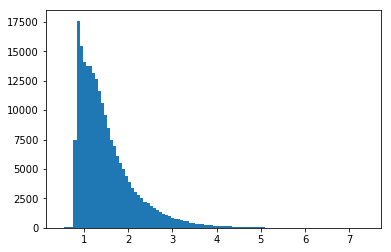

In [48]:
plt.hist(np.array(lst).mean(0).reshape([-1]),bins=100);

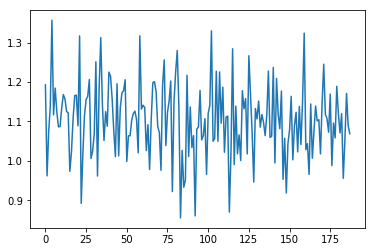

In [49]:
plt.plot(np.array(lst)[:,0,120]);

In [50]:
rawy[:,:,1688]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float16)

In [51]:
amodel=keras.models.load_model(a.name,custom_objects={'TransformNALayer':TransformNALayer, 'RMSE':RMSE})
for i in [1688]:
    ax=train_test[:,:,i].reshape([-1,train_test.shape[-1]])
    yy_pred3=amodel.predict(ax,4096)[:,0].reshape(train_test.shape[:2])
print yy_pred3.shape
pickle.dump(yy_pred3,open(a.name+".pred",'wb'))

(54, 4100)


In [52]:
c=np.arange(60).reshape([3,4,5])

In [53]:
(c.reshape([-1,5]).reshape([3,4,5])==c).all()

True